In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


#theano imports
import lasagne
import theano
import theano.tensor as T
import sys
sys.setrecursionlimit(100000)
floatX = theano.config.floatX



In [2]:
%load_ext autoreload
%autoreload 2

# Stack-augmented RNN
![caption](https://usercontent1.hubstatic.com/6172838_f260.jpg)



This notebook reproduces experiment from article http://arxiv.org/abs/1503.01007

## Task and architecture

__The task__ is to train an RNN to generate sequences from expression `|`$ a^n b^m c^{n+m} $
 * n and m are integers
 * Performance metrics:
  * Correct format - `|`, some a, some b, some c
     * ||aaacbbcba would be an example of incorrect one
  * Number of C letters to be as close to sum of A band B letters as possible
     * Ideally, #c = #a + #b
     

Model we use:
 * Stack-augmented RNN
 
Trained as a language model (predicting next symbols given preceding history)

### Sequence generator

In [3]:
def generate_sequence(batch_size = 10,crop_length = 100 ):
    """
    Generates sequence from pattern [0  1*n 2*m 3*(n+m)]
    """
    sequences=[]
    for i in range(batch_size):
        seq = [0]
        while len(seq) < crop_length:
            n,m = np.random.randint(1,10,2)
        
            seq += [0]+ [1]*n+[2]*m+[3]*(n+m)
        seq = seq[:crop_length]
        sequences.append(seq)
    return np.array(sequences,dtype='int32')

alphabet = np.array(list('|abc'))

In [4]:
#quality evaluation
from operator import add
import re
def get_metrics(gen_sequences,alphabet):    
    strings = map(lambda v:reduce(add,v), map(alphabet.__getitem__,gen_sequences))
    
    #at least one complete string
    strings = filter(lambda v: '|' in v,strings)
    
    #cut off last unfinished string, if any
    
    strings = map(lambda v: v[:-1-v[::-1].index('|')],strings)
    
    all_strings = '|'.join(strings)
    
    
    
    seqs = filter(len,all_strings.split('|'))
    
    matches = map(lambda seq:re.match(r"^a+b+c+",seq),seqs)
    
    is_correct = map( lambda seq,m: m is not None and m.pos==0 and m.endpos == len(seq), 
                        seqs, matches)
    
    
    
    
    correct_seqs = np.array(seqs)[np.array(is_correct,dtype='bool')]
    
    seqs_error = map(lambda s: s.count('a')+ s.count('b') - s.count('c'),correct_seqs)
    
    return np.mean(is_correct), np.mean(np.abs(seqs_error))


### samples

In [5]:
%%time
map(''.join,map(alphabet.__getitem__,generate_sequence(5,100)))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 519 µs


['||aaaaabbbbbbbbccccccccccccc|aabbbbbbbbbccccccccccc|abbbcccc|aaaaaabbbccccccccc|abbccc|abbbcccc|aaaa',
 '||aaaaaaaaabbbbccccccccccccc|abbbbbbccccccc|aaaaaaabbbbbbccccccccccccc|aaaaaabbbbbccccccccccc|aaaaaa',
 '||aaaaaaabbccccccccc|aaaabbbbcccccccc|aabbbccccc|aaaaaaaabccccccccc|aaabbbbbbbbbcccccccccccc|aaaaaaa',
 '||aabbbbcccccc|aaaaaaabbccccccccc|aaaaaaaaabbbbbbbbccccccccccccccccc|aaaaaaabbbbbbbbbccccccccccccccc',
 '||aaaaaaabbccccccccc|aaaaaaabbbbbbbcccccccccccccc|aaaaaaaabbcccccccccc|aaabbbbbbbbbcccccccccccc|aaab']

# Constants

In [6]:
# length of training/generation sequence
SEQ_LENGTH = 50

# Sequences in a minibatch
BATCH_SIZE = 100

# Total epochs
N_EPOCHS = 5000

#how often to print metrics
REPORT_RATE = 100

In [7]:
#Reference sequences for training
sequences_batch = T.matrix(dtype="int32",name="reference_sequences")

#Batch size (theano expression)
batch_size = sequences_batch.shape[0]


# Define RNN

A "simple" scheme of what was there in the paper, followed exactly by the code below

* Time goes from left to right
* Layers start at the bottom and go up
* memory states are green, memory updates are purple
* inputs and outputs are blue traingles
* transformations are in pale yellow

![canvas](http://s32.postimg.org/vefrk7vqt/stack_gru.png)

In [8]:
import lasagne
from lasagne.layers import DenseLayer, ConcatLayer, InputLayer, EmbeddingLayer

import agentnet
from agentnet.resolver import ProbablisticResolver

from agentnet.agent import Generator
from agentnet.memory import GRUMemoryLayer, StackAugmentation


In [9]:


#input letter goes here
output_shape = (None,)
observation_layer = InputLayer(output_shape,name="obs_input")


# embedding the input layer
n_tokens = len(alphabet)
obs_embedding = EmbeddingLayer(observation_layer,
                                              input_size=n_tokens,
                                              output_size=n_tokens,
                                              name = "input_embedding")




#GRU n units
n_hid_1 = 32

#previous GRU state goes here
prev_gru_layer = InputLayer((None,n_hid_1),name="prev_rnn_state")


# previous stack goes here
stack_width = 3
stack_depth = 50
prev_stack_layer = InputLayer((None,stack_depth,stack_width))






# Stack controls - push, pop and no-op
stack_controls_layer = lasagne.layers.DenseLayer(prev_gru_layer,3,
                                                nonlinearity= lasagne.nonlinearities.softmax,
                                                name = "stack controls")

# stack input
stack_input_layer = lasagne.layers.DenseLayer(prev_gru_layer,stack_width,
                                             nonlinearity = lasagne.nonlinearities.tanh,
                                             name = "stack input")
    
    
#new stack state  
next_stack = StackAugmentation(stack_input_layer,
                              prev_stack_layer,
                              stack_controls_layer)


#stack top (used for RNN)
stack_top = lasagne.layers.SliceLayer(next_stack,0,1)



#new GRU state
gru = GRUMemoryLayer(n_hid_1,
                     ConcatLayer([obs_embedding,stack_top]),
                     prev_gru_layer)



# Recurrent state dictionary: maps state outputs to prev_state inputs
from collections import OrderedDict
memory_dict = OrderedDict([
            (gru,prev_gru_layer),
            (next_stack, prev_stack_layer)
    ])




##Outputs

# next letter probabilities

probability_layer = lasagne.layers.DenseLayer(gru,
                                         num_units = n_tokens,
                                         nonlinearity=  lasagne.nonlinearities.softmax,
                                         name="policy_original")

#resolver picks a particular letter in generation mode

resolver = ProbablisticResolver(probability_layer,
                                assume_normalized=True,
                                name="resolver")


#verify that letter shape matches
assert tuple(lasagne.layers.get_output_shape(resolver)) == tuple(output_shape)






#Create a generator
# - eats letters as observation, one at a time
# - has a number of "memory" variables, defined by memory dict
# - generates letters proportional to probability layer
# - the final letter is decided at resolver layer

agent = Generator(
    observation_layer,
    memory_dict,
    probability_layer,
    resolver
    )


# Unroll the recurrence

* returns sessions of shape [batch_size, sequence_length, variable_size] for each variable

In [10]:
sessions = agent.get_sessions(session_length=SEQ_LENGTH,
                             recorded_sequences=sequences_batch,
                             batch_size=batch_size,)


# rec states    -    generated letters  - predicted probabilities
agent_states,          action_seq,           probas_seq       =  sessions


# gru state sequence (can extract stack likewise)
rnn_seq = agent_states[gru]


# for this task we only need probabilities :)
# probas_seq


### The rest is a regular lasagne

### Weights

In [11]:
#Obtain them
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[input_embedding.W,
 stack input.W,
 stack input.b,
 stack controls.W,
 stack controls.b,
 YetAnotherGRUMemoryLayer.W_in_to_updategate,
 YetAnotherGRUMemoryLayer.W_hid_to_updategate,
 YetAnotherGRUMemoryLayer.b_updategate,
 YetAnotherGRUMemoryLayer.W_in_to_resetgate,
 YetAnotherGRUMemoryLayer.W_hid_to_resetgate,
 YetAnotherGRUMemoryLayer.b_resetgate,
 YetAnotherGRUMemoryLayer.W_in_to_hidden_update,
 YetAnotherGRUMemoryLayer.W_hid_to_hidden_update,
 YetAnotherGRUMemoryLayer.b_hidden_update,
 policy_original.W,
 policy_original.b]

In [12]:
total_weights = int(T.sum([T.prod(w.shape) for w in weights]).eval())
print "Total weights:", total_weights


Total weights: 4186


# Loss function

simple crossentropy

In [13]:

# take all predicitons but for last one (we don't have it's 'next')
predicted_probas = probas_seq[:,:-1]

# crop probabilities to avoid -Inf logarithms
predicted_probas = T.maximum(predicted_probas,1e-10)

# correct answers
references = sequences_batch[:,1:]



# familiar lasagne crossentropy
model_loss = lasagne.objectives.categorical_crossentropy(
    predicted_probas.reshape([-1,n_tokens]),
    references.ravel()
).mean()





In [14]:
#Regularizer for kicks
from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver,l2)*10**-5
loss = model_loss + reg_l2


In [15]:
updates = lasagne.updates.adadelta(loss,weights,learning_rate=0.1)

# Compile the training and evaluation steps

* Since we unroll scans, the first compile may take approx. 3.5 cups of tea
* If you want it to just compile something, consider either of the two:
 * turning off optimizer
 * reducing sequence length to, say, 20

In [16]:
train_fun = theano.function([sequences_batch],[loss],updates=updates)
evaluation_fun = theano.function([sequences_batch],[loss,model_loss,reg_l2])

# Generating letters recurrently
* In this mode, generator's i+1'st input is it's i-th output
* the only difference in terms of code is that we do not provide reference sequence

In [17]:
# generation batch size
gen_batch_size = T.scalar('generated batch size','int32')


_,generated_action_seq,_ = agent.get_sessions(session_length=SEQ_LENGTH,
                             batch_size=gen_batch_size,)


In [18]:
# ~0.5 tea cups
get_sequences = theano.function([gen_batch_size],generated_action_seq)

In [19]:
#sample output
map(alphabet.__getitem__,get_sequences(3))

[array(['c', 'a', 'b', 'c', 'c', '|', 'b', 'a', 'c', 'a', '|', 'c', 'b',
        'a', 'b', 'a', 'a', 'c', 'c', 'c', 'a', '|', 'c', 'a', 'a', 'b',
        'b', 'b', '|', '|', '|', 'c', 'c', '|', 'c', 'c', 'a', '|', 'a',
        'a', '|', 'b', 'c', '|', 'c', 'a', 'b', 'b', 'b', 'c'], 
       dtype='|S1'),
 array(['a', 'c', 'c', '|', '|', 'a', 'a', 'b', '|', 'a', 'a', '|', 'b',
        'b', 'c', 'b', 'a', 'a', 'c', 'b', 'b', 'a', 'c', 'c', 'c', '|',
        'b', '|', '|', 'a', '|', '|', 'a', 'c', 'b', 'b', 'b', '|', 'c',
        'b', 'c', 'c', 'c', 'b', 'c', 'c', 'a', 'b', '|', '|'], 
       dtype='|S1'),
 array(['a', 'b', 'a', 'c', '|', '|', 'a', '|', 'b', '|', '|', '|', 'b',
        'b', 'b', 'b', 'a', 'c', 'c', 'b', 'b', '|', 'b', '|', 'a', 'b',
        'c', 'c', 'a', '|', 'c', 'c', 'b', '|', '|', '|', 'b', 'b', 'a',
        '|', 'a', 'c', '|', 'a', 'a', 'b', 'a', 'b', '|', '|'], 
       dtype='|S1')]

# Training loop:

* Generating sequences
* Training on them
* Printing metrics every once in a while

In [20]:
from collections import defaultdict

metrics = defaultdict(dict)

In [21]:

for i in range(N_EPOCHS):
    
    #generate reference
    new_batch = generate_sequence(BATCH_SIZE,SEQ_LENGTH)
    #feed the monster
    train_fun(new_batch)
    
    #Display metrics once in a while
    if i % REPORT_RATE==0:
        
        loss_components = evaluation_fun(new_batch)
        print "iter:%i\tfull:%.5f\tllh:%.5f\treg:%.5f"%tuple([i]+map(float,loss_components))        
        
        metrics['crossentropy'][i]=float(loss_components[1])
        

        examples = get_sequences(1000)
        
        correctness_ratio,c_count_mae = get_metrics(examples,alphabet)
        

        metrics["correctness_rates"][i] = correctness_ratio
        metrics["c_count_errors"][i]=c_count_mae
        
        print "Correct sequences ratio: %.5f"%(correctness_ratio)
        print "C-s count mean abs error: %.5f"%(c_count_mae)
        
        for tid_line in examples[:3]:
            print ' '.join(map(alphabet.__getitem__,tid_line))

    

iter:0	full:1.38536	llh:1.38483	reg:0.00053
Correct sequences ratio: 0.03639
C-s count mean abs error: 2.49401
a c | b | a b | b a | a c c | b a c c c b c c a | a b c b | a a a a | a c | | | c c a | b | | a a |
a a | a b b b b b c a b c c b c c b | c | c | b | | a | | b a a | b | b b b a b | c c a c c | a | a
c a c a b a b a a b b | c b | | | b | | | c | c b a a b c c a a a | a | | c a a c | a c a a | a | a
iter:100	full:1.18011	llh:1.17956	reg:0.00055
Correct sequences ratio: 0.05154
C-s count mean abs error: 2.88393
a c c c a a c c | c a a c c c c c a b | | a c c b b c b a a | b a c a b a c b a b b b a b c a | c b
c c b c b b | c b c c c c c a b a a | a c b c c c c c b a | b b b c c | c b c | a b b | b c c b b |
c b b a b a | c | b c c b b c b c b a a c b a a c b b | c a c c c | c c b c c c c c c c a b a | c c
iter:200	full:0.71452	llh:0.71390	reg:0.00062
Correct sequences ratio: 0.06956
C-s count mean abs error: 4.24186
a b b c c c c c c | c b b c b b c b b a c c c | a b b c a b c a

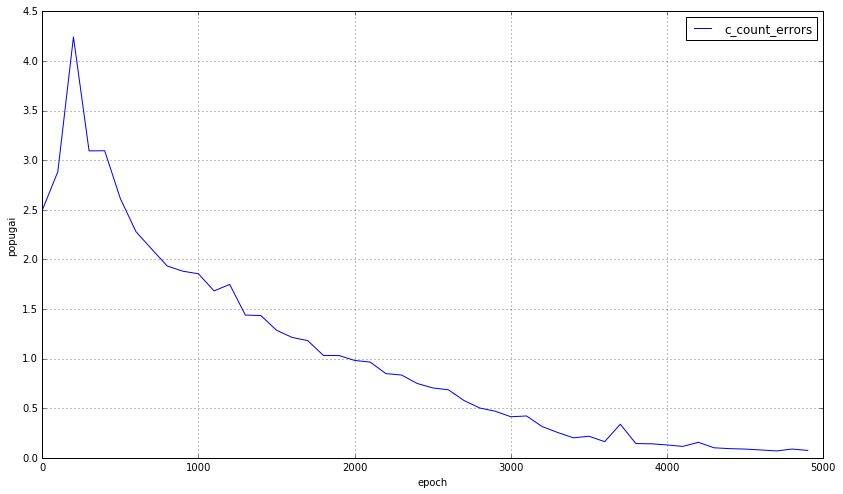

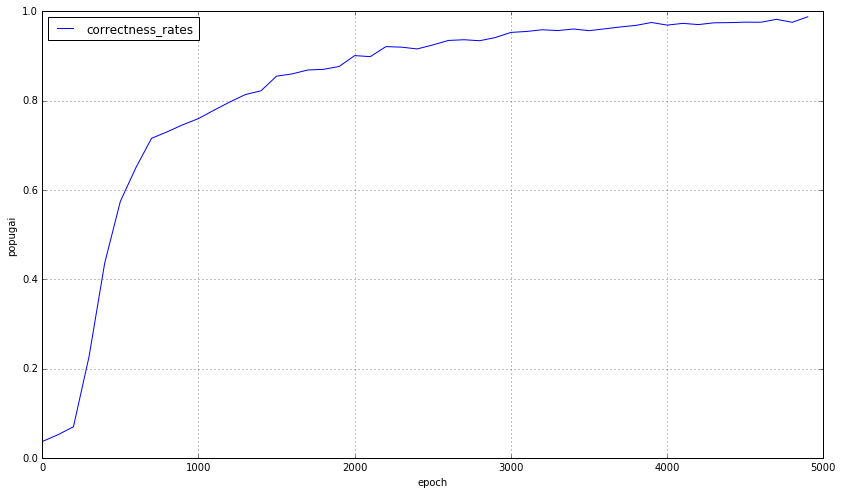

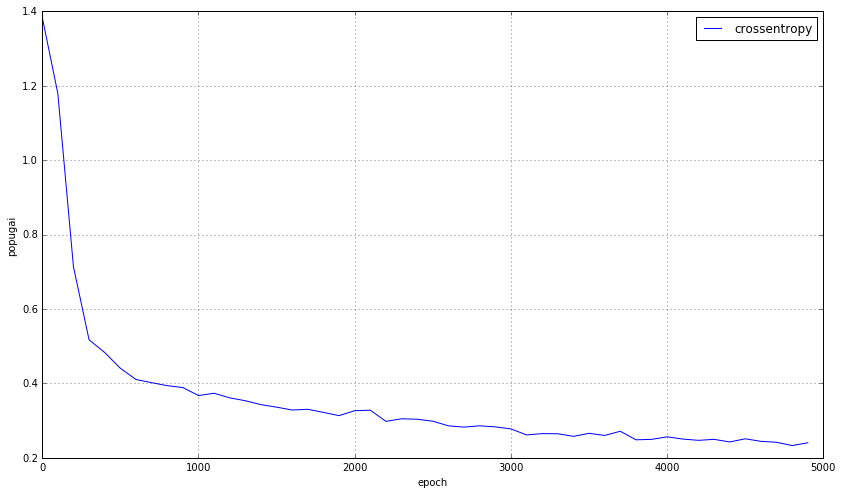

In [22]:
for metric in metrics:
    plt.figure(figsize=[14,8])
    plt.plot(*zip(*sorted(metrics[metric].items(),key=lambda (k,v):k)),label=metric)
    plt.legend(loc='best')
    plt.ylabel("popugai")
    plt.xlabel("epoch")
    plt.grid()